In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import untils
from graph import graph
import train2

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


In [2]:
random_seed = 1234
untils.fix_seed(random_seed)

In [3]:
# gpu
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

# path
data_root = Path('/home/zhanggy/STitch3D/data/DLPFC dataset/spatialLIBD/')

# sample name
sample_name = '151674'
n_clusters = 5 if sample_name in ['151669', '151670', '151671', '151672'] else 7

input_dir = os.path.join(data_root, sample_name)

In [4]:
adata = sc.read_visium(path=input_dir ,count_file=sample_name+'_filtered_feature_bc_matrix.h5' )
adata.var_names_make_unique()

In [5]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)
adata = adata[:, adata.var['highly_variable'] == True]
adata


View of AnnData object with n_obs × n_vars = 3673 × 3000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

In [6]:
from sklearn.decomposition import PCA
im_re = pd.read_csv("/home/zhanggy/STitch3D/data/DLPFC dataset/spatialLIBD/{}/image_representation/ViT_pca_representation.csv".format(sample_name, sample_name), header=0, index_col=0, sep=',')
gene_he = np.concatenate((im_re.to_numpy(), adata.X.toarray()), axis=1)
pca = PCA(n_components=200,random_state=42)
pca.fit(gene_he)
adata.obsm["gene_he"] = pca.transform(gene_he)

sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.scale(adata)
adata = adata[:, adata.var['highly_variable'] == True]

In [10]:
graph_dict = graph(adata.obsm["spatial"], distType="BallTree", k=6, rad_cutoff=150).main()
labels = graph_dict['adj_label']
graph_dict

6.0000 neighbors per cell on average.


{'adj_norm': SparseTensor(row=tensor([   0,    0,    0,  ..., 3672, 3672, 3672]),
              col=tensor([   0,  397,  486,  ..., 2516, 3434, 3672]),
              val=tensor([0.1429, 0.1429, 0.1429,  ..., 0.1429, 0.1429, 0.1429]),
              size=(3673, 3673), nnz=26263, density=0.19%),
 'adj_label': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 'norm_value': 0.5008386334795998}

In [11]:
im_re = pd.read_csv("/home/zhanggy/STitch3D/data/DLPFC dataset/spatialLIBD/{}/image_representation/ViT_pca_representation.csv".format(sample_name, sample_name), header=0, index_col=0, sep=',')
pca = PCA(n_components=200)
pca.fit(im_re.to_numpy())
adata.obsm["im_re"] = pca.transform(im_re.to_numpy())

In [12]:
celltype = pd.read_csv(f"/home/zhanggy/SPACEL/{sample_name}_celltype.csv", index_col=0)
adata.obsm['celltype'] = celltype.values

In [13]:
Ann_df = pd.read_csv(f"/home/zhanggy/STitch3D/data/DLPFC dataset/spatialLIBD/{sample_name}/{sample_name}_truth.txt", sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']

In [14]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

In [15]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [16]:
random_seed = 2000
untils.fix_seed(random_seed)

In [ ]:
PRISM_net = PRISM(adata.obsm['gene_he'],adata.obsm['celltype'], graph_dict=graph_dict, device=device)


using_dec = True
if using_dec:
    PRISM_net.train_with_dec(N=1)
    
else:
    PRISM_net.train_without_dec(N=1)
    
PRISM_feat, _ = PRISM_net.process()
adata.obsm['emb'] = PRISM_feat

100%|██████████| 2000/2000 [00:39<00:00, 50.08it/s]


In [20]:
# mclust
untils.clustering(adata, n_clusters, radius=50, key='emb', method='mclust')

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


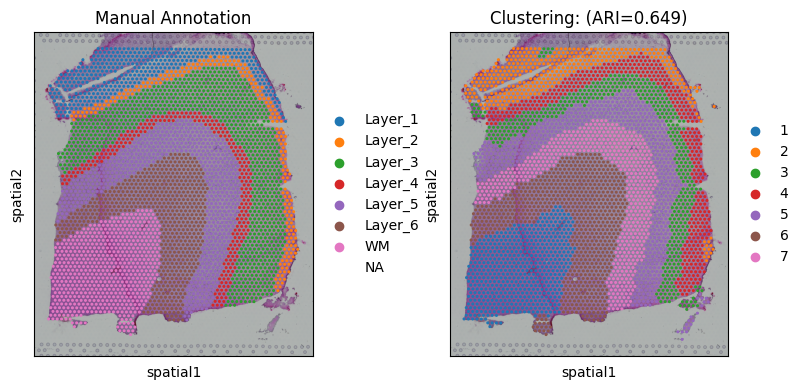

In [21]:
sub_adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['Ground Truth'], sub_adata.obs['domain'])
%matplotlib inline
fig, axes = plt.subplots(1,2,figsize=(4*2, 4))
sc.pl.spatial(adata, color='Ground Truth', ax=axes[0], show=False)
sc.pl.spatial(adata, color='domain', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering: (ARI=%.3f)' % ARI)
plt.tight_layout()
plt.show()

In [22]:
print(ARI)

0.649299554835832


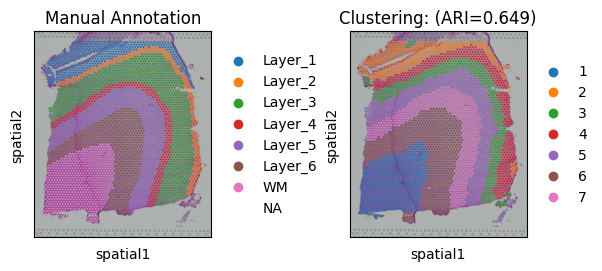

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['Ground Truth'], sub_adata.obs['domain'])
%matplotlib inline
fig, axes = plt.subplots(1,2,figsize=(3*2, 3))
sc.pl.spatial(adata, color='Ground Truth', ax=axes[0], show=False)
sc.pl.spatial(adata, color='domain', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering: (ARI=%.3f)' % ARI)
plt.tight_layout()
plt.show()

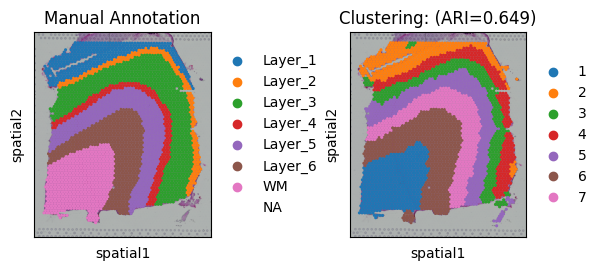

In [ ]:
sub_adata = adata[~pd.isnull(adata.obs['Ground Truth'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['Ground Truth'], sub_adata.obs['domain'])
%matplotlib inline
fig, axes = plt.subplots(1,2,figsize=(3*2, 3))
sc.pl.spatial(adata, img_key='hires',size=1.6,color='Ground Truth', ax=axes[0], show=False)
sc.pl.spatial(adata, img_key='hires',size=1.6,color='domain', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering: (ARI=%.3f)' % ARI)
plt.tight_layout()
plt.show()

untils.clustering(adata, n_clusters=7, radius=50, key='emb', method='louvain',start=0.1,end=1.0, increment=0.01)

untils.mclust_R(adata, n_clusters, use_rep='emb', key_added='SEDR')

In [25]:
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['Ground Truth'], sub_adata.obs['domain'])
print('NMI:%.4f'%NMI)

NMI:0.7558


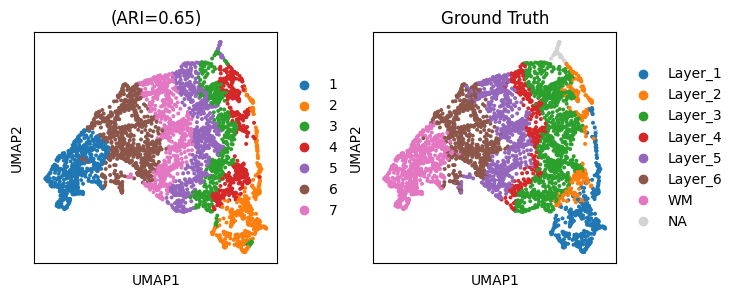

In [ ]:
sc.pp.neighbors(adata, use_rep='emb')
sc.tl.umap(adata)
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["domain", "Ground Truth"], title=['(ARI=%.2f)'%ARI, "Ground Truth"],show=False)
plt.show()

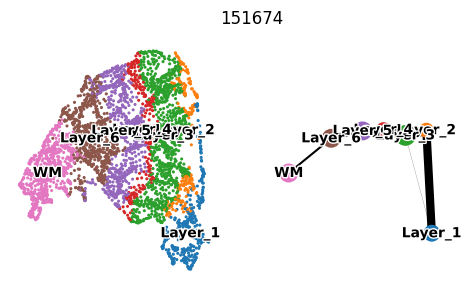

In [ ]:
used_adata = adata[pd.notna(adata.obs['Ground Truth'])]
sc.tl.paga(used_adata, groups='Ground Truth')
plt.rcParams["figure.figsize"] = (3,3)
sc.pl.paga_compare(used_adata, legend_fontsize=10, frameon=False, size=20,
                   title=sample_name, legend_fontoutline=2, show=False)
plt.show()